In [1]:
# Jax imports
import jax
import jax.numpy as jnp
import numpy as np
from jax import config

config.update("jax_enable_x64", False)

In [2]:
from matplotlib import pyplot as plt

In [3]:
# IO utils
from jax_2dtm.io import load_grid_as_cloud

In [4]:
# Image simulator
from jax_2dtm.simulator import NufftScattering
from jax_2dtm.simulator import ScatteringImage, OpticsImage, GaussianImage
from jax_2dtm.simulator import AntiAliasingFilter, WhiteningFilter, CircularMask
from jax_2dtm.simulator import EulerPose, CTFOptics, Intensity, ExponentialNoise, WhiteNoise, ParameterState
from jax_2dtm.utils import ifft, fftfreqs

In [5]:
# Volume filename and metadata
pixel_size = 5.28  # Angstroms
filename = "../tests/data/3jar_13pf_bfm1_ps5_28.mrc"
#pixel_size = 1.32  # Angstroms
#filename = "3jar_13pf_bfm1_ps1_32.mrc"

In [6]:
# Configure image data and read template as point cloud
#config = FourierSliceScattering((220, 220), pixel_size, pad_scale=1)
#cloud = load_grid_as_cloud(filename, config, real=False, flatten=False)
config = NufftScattering((95, 95), pixel_size, pad_scale=2.2, eps=1e-5)
#config = GaussianScattering((320, 320), pixel_size, pad_scale=1.4, scale=1/3)
cloud = load_grid_as_cloud(filename, config, atol=1e-6)

In [7]:
# Initialize model, parameters, and compute image
pose = EulerPose(-30.0, 20.0, np.pi / 2, np.pi / 10, -np.pi / 6)
optics = CTFOptics()
noise = ExponentialNoise(key=jax.random.PRNGKey(seed=0), kappa=0.1, xi=6.0, alpha=0.5)
intensity = Intensity()
state = ParameterState(pose=pose, optics=optics, noise=noise, intensity=intensity)

In [8]:
scattering_model = ScatteringImage(config=config, cloud=cloud, state=state)
optics_model = OpticsImage(config=config, cloud=cloud, state=state, masks=[])
noisy_model = GaussianImage(config=config, cloud=cloud, state=state)

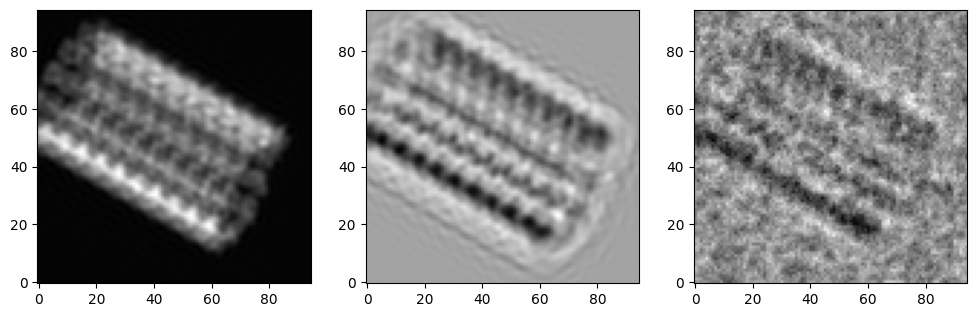

In [9]:
# Plot models
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))
ax1, ax2, ax3 = axes
im1 = ax1.imshow(ifft(scattering_model()), origin="lower", cmap="gray")
im2 = ax2.imshow(ifft(optics_model()), origin="lower", cmap="gray")
im3 = ax3.imshow(ifft(noisy_model()), origin="lower", cmap="gray")

Now, let's test altering the image filters.

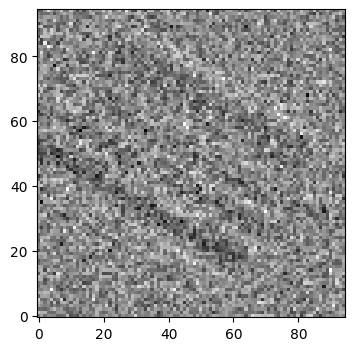

In [10]:
# Instantiate image filters
fig, ax = plt.subplots(figsize=(4, 4))
micrograph_freqs = fftfreqs((800, 600), pixel_size)
micrograph = noise.sample(config.pixel_size * micrograph_freqs)
whiten = WhiteningFilter(config.pixel_size * config.freqs, config.pixel_size * micrograph_freqs, micrograph)
plt.imshow(ifft(whiten(noisy_model())), origin="lower", cmap="gray")

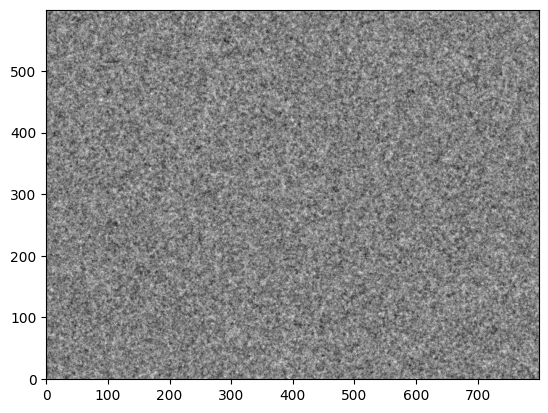

In [11]:
plt.imshow(ifft(micrograph).T, origin="lower", cmap="gray")

We see that the whitening filter looks right, empirically! Now generate an image at a colored noise model with a given whitening filter

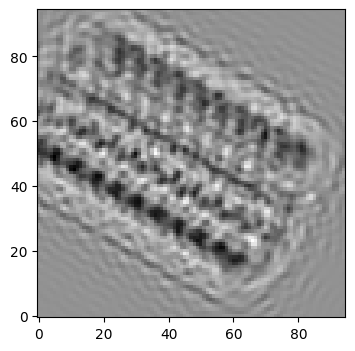

In [12]:
# Show forward model for a whitened image
fig, ax = plt.subplots(figsize=(4, 4))
white_noise = WhiteNoise(key=jax.random.PRNGKey(seed=0), alpha=1.0)
filters = [AntiAliasingFilter(config.pixel_size * config.padded_freqs), WhiteningFilter(config.pixel_size * config.padded_freqs, config.pixel_size * micrograph_freqs, micrograph)]
filtered_model = GaussianImage(config=config, cloud=cloud, state=state, filters=filters)
ax.imshow(ifft(filtered_model.render()), origin="lower", cmap="gray")

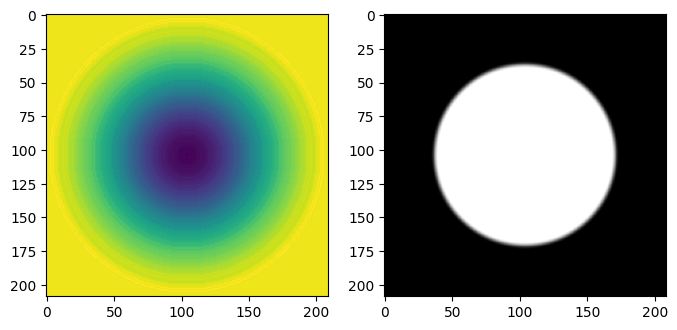

In [13]:
# Visualize filters
fig, axes = plt.subplots(ncols=2, figsize=(8, 6))
ax1, ax2 = axes
antialias, whiten = filters
im1 = ax1.imshow(whiten.filter, cmap="viridis")
im2 = ax2.imshow(antialias.filter, cmap="gray")

Computing an image is straight-forward, but really we want to define a function that can be arbitrarily transformed by JAX and evaulated at subsets of the parameters.

In [14]:
# Define subset of parameters over which to evaluate model, and jitted model
params = dict(view_phi=np.pi, defocus_u=9000.0, sigma=1.0, N=1.0, mu=10.0)
jitted_noisy_model = jax.jit(lambda params: noisy_model(params))

In [15]:
# Benchmark jitted pipeline
# jitted_noisy_image = jitted_noisy_model(params)

In [16]:
# Benchmark non-jitted pipeline
noisy_image = noisy_model(params)

Now, we can also use the model to compute the likelihood. Let's evaulate the likelihood at the simulated data, and visualize the residuals.

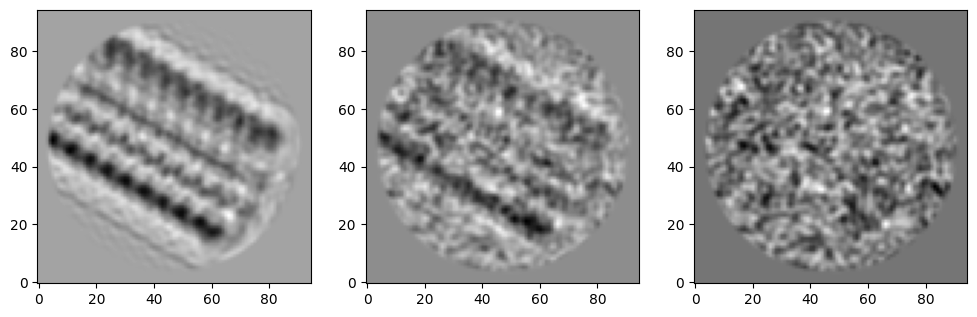

In [18]:
# Initialize the model and plot residuals
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))
ax1, ax2, ax3 = axes
noisy_model = GaussianImage(config=config, cloud=cloud, state=state, masks=[], filters=[])
observed = noisy_model()
masks = [CircularMask(config.coords/config.pixel_size)]
model = GaussianImage(config=config, cloud=cloud, state=state, masks=masks, observed=observed)
simulated, observed, residuals = model.render(), model.observed, model.residuals()
ax1.imshow(ifft(simulated), origin="lower", cmap="gray")
ax2.imshow(ifft(observed), origin="lower", cmap="gray")
ax3.imshow(ifft(residuals), origin="lower", cmap="gray")


In [ ]:
# Compute likelihood
loss = lambda params: model(params)# jax.jit(lambda params: model(params))
grad_loss = jax.grad(lambda params: model(params))#jax.jit(jax.grad(lambda params: model(params)))

In [ ]:
# Benchmark jitted pipeline
%timeit likelihood = loss(params)

25.5 ms ± 842 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# Benchmark gradient
%timeit grad = grad_loss(params)

83.6 ms ± 953 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
